# Generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## Steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"
%nuclio config spec.maxReplicas = 1

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'
%nuclio: setting spec.maxReplicas to 1


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact
from mlrun.mlutils import (get_sample, get_splits,
                     gen_sklearn_model, create_class, eval_model_v2)

import mlrun

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.70,
    test_set_key: str = "test_set",
    model_evaluator = None,
    models_dest: str = "",
    plots_dest: str = "plots",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier
    
    An optional cutom model evaluator can be supplied that should have the signature:
    `my_custom_evaluator(context, xvalid, yvalid, model)` and return a dictionary of 
    scalar "results", a "plots" keys with a list of PlotArtifacts, and 
    and "tables" key containing a returned list of TableArtifacts.
    
    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param test_set_key:      key of held out data in artifact store
    :param model_evaluator:   (None) a custom model evaluator can be specified
    :param models_dest:       ("") models subfolder on artifact path
    :param plots_dest:        plot subfolder on artifact path
    :param file_ext:          ("parquet") format for test_set_key hold out data
    :param random_state:      (1) sklearn rng seed

    """
    models_dest = models_dest or "model"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train, validate, and test sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    # set aside some test data
    context.log_dataset(test_set_key, 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1),
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))

    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": xtrain,
                                "y": ytrain.values})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # and run `fit` with our updated FIT params:
    model.fit(**model_config["FIT"])
    
    # evaluate model:
    artifact_path = context.artifact_subpath(models_dest)
    plots_path = context.artifact_subpath(models_dest, plots_dest)
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model,
                                       plots_artifact_path=plots_path)
    else:
        eval_metrics = eval_model_v2(context, xvalid, yvalid, model,
                                     plots_artifact_path=plots_path)
        
    # log it all:
    context.set_label('class', model_pkg_class)
    context.log_model("model", body=dumps(model),
                      artifact_path=artifact_path,
                      extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": model_pkg_class})

In [4]:
# nuclio: end-code

### Sklearn trainer setup

the following task paramaters are common to all runs

In [5]:
task_params = {
    #"name" : "sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.70,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### Set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [6]:
DATA_URL = 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'

> 2020-10-28 15:07:07,185 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match
> 2020-10-28 15:07:07,192 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match
> 2020-10-28 15:07:07,192 [info] starting run sklearn_ensemble_RandomForestClassifier uid=7828bb4ac6c142f1bb30e7e2d289d5fc  -> http://mlrun-api:8080
> 2020-10-28 15:07:07,228 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...d289d5fc,0,Oct 28 15:07:07,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-d87678b84-n4lcfclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,accuracy=0.90625test-error=0.09375auc-micro=0.99365234375auc-weighted=0.9970043572984749f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 7828bb4ac6c142f1bb30e7e2d289d5fc --project default , !mlrun logs 7828bb4ac6c142f1bb30e7e2d289d5fc --project default
> 2020-10-28 15:07:12,648 [info] run executed, status=completed
> 2020-10-28 15:07:12,654 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match
> 2020-10-28 15:07:12,655 [info] starting run sklearn_linear_model_LogisticRegression uid=8ebc46982a4c4084899b61977343609a  -> http://mlrun-api:8080
> 2020-10-28 15:07:12,690 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...7343609a,0,Oct 28 15:07:12,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=handlerowner=adminhost=jupyter-d87678b84-n4lcfclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,accuracy=0.875test-error=0.125auc-micro=0.97265625auc-weighted=0.997004357298475f1-score=0.8534798534798534precision_score=0.8518518518518517recall_score=0.9111111111111111,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 8ebc46982a4c4084899b61977343609a --project default , !mlrun logs 8ebc46982a4c4084899b61977343609a --project default
> 2020-10-28 15:07:14,513 [info] run executed, status=completed
> 2020-10-28 15:07:14,519 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match
> 2020-10-28 15:07:14,520 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=069ab66c7dc749f8a7cdb316be3c35db  -> http://mlrun-api:8080
> 2020-10-28 15:07:14,555 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...be3c35db,0,Oct 28 15:07:14,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-d87678b84-n4lcfclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,accuracy=0.90625test-error=0.09375auc-micro=0.96044921875auc-weighted=1.0f1-score=0.886039886039886precision_score=0.875recall_score=0.9333333333333332,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 069ab66c7dc749f8a7cdb316be3c35db --project default , !mlrun logs 069ab66c7dc749f8a7cdb316be3c35db --project default
> 2020-10-28 15:07:17,202 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

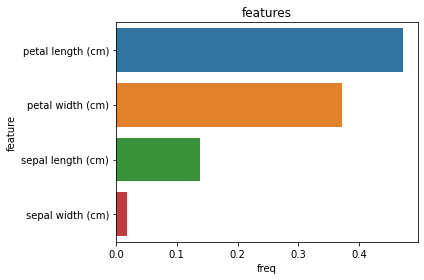

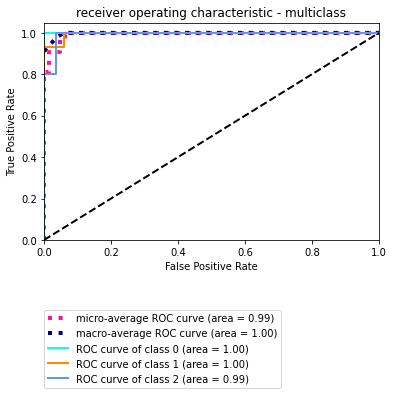

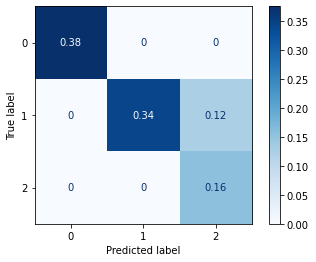

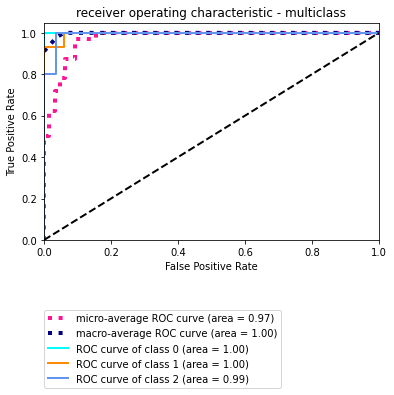

<Figure size 432x288 with 0 Axes>

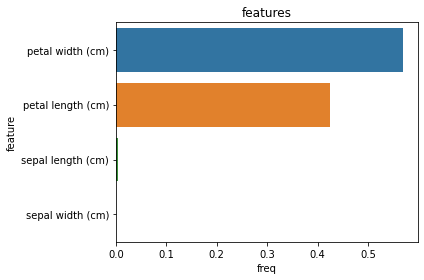

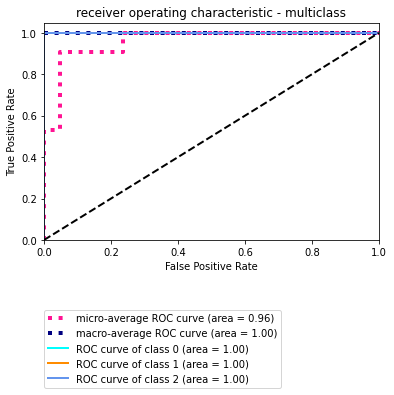

In [7]:
artifact_path = mlrun.set_environment(api_path = 'http://mlrun-api:8080',
                                      artifact_path = os.path.abspath('./'))

outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = mlrun.run_local(mlrun.NewTask(**task_copy),
                             handler=train_model,
                             name=name,
                             inputs={"dataset"  : DATA_URL}, 
                             artifact_path=os.path.join(artifact_path, model))
    
    outputs.append({name: output.outputs})


### Save

In [8]:
# create job function object from notebook code
fn = mlrun.code_to_function("sklearn_classifier", 
                            handler="train_model",
                            description="train any classifier using scikit-learn's API",
                            categories=["ml", "training"],
                            labels = {"author": "yjb", "framework": "sklearn"},
                            code_output='.')

# add metadata (for templates and reuse)
fn.export("function.yaml")

> 2020-10-28 15:07:28,688 [info] function spec saved to path: function.yaml


### Tests - Run remotely

In [9]:
fn.apply(mlrun.platforms.auto_mount())

In [10]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = fn.run(mlrun.NewTask(**task_copy),
                             handler=train_model,
                             name=name,
                             inputs={"dataset"  : DATA_URL}, 
                             artifact_path=os.path.join(artifact_path, model))
    
    outputs.append({name: output.outputs})

> 2020-10-28 15:07:28,715 [warning] warning!, server (0.5.3-rc1) and client (0.5.2) ver dont match
> 2020-10-28 15:07:28,716 [info] starting run sklearn_ensemble_RandomForestClassifier uid=e10b0a9b81cb42b48116ba59a2851375  -> http://mlrun-api:8080
> 2020-10-28 15:07:28,905 [info] Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-kr5t5


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...a2851375,0,Oct 28 15:07:28,running,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=jobowner=admin,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run e10b0a9b81cb42b48116ba59a2851375 --project default , !mlrun logs e10b0a9b81cb42b48116ba59a2851375 --project default
> 2020-10-28 15:07:28,964 [info] run executed, status=running
> 2020-10-28 15:07:28,965 [info] starting run sklearn_linear_model_LogisticRegression uid=ccf66a211ed44789ae62bd9a71439543  -> http://mlrun-api:8080
> 2020-10-28 15:07:29,103 [info] Job is running in the background, pod: sklearn-linear-model-logisticregression-gdcrk


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...71439543,0,Oct 28 15:07:29,running,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=jobowner=admin,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run ccf66a211ed44789ae62bd9a71439543 --project default , !mlrun logs ccf66a211ed44789ae62bd9a71439543 --project default
> 2020-10-28 15:07:29,164 [info] run executed, status=running
> 2020-10-28 15:07:29,165 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=4cbdeb89e6784f8b826102ed7a3bc24b  -> http://mlrun-api:8080
> 2020-10-28 15:07:29,414 [info] Job is running in the background, pod: sklearn-ensemble-adaboostclassifier-h6svl


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...7a3bc24b,0,Oct 28 15:07:29,running,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=jobowner=admin,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4cbdeb89e6784f8b826102ed7a3bc24b --project default , !mlrun logs 4cbdeb89e6784f8b826102ed7a3bc24b --project default
> 2020-10-28 15:07:29,496 [info] run executed, status=running
